## Feature Crosses

 A feature cross is a synthetic feature formed by multiplying two or more features.

In [1]:
from google.cloud import bigquery

### Feature Crosses in BigQuery

We'll first explore how to create a feature cross in BigQuery. The cell below will create a dataset called `babyweight` in your GCP project, if it does not already exist. This dataset will will house our tables and models. 

In [2]:
bq = bigquery.Client()
dataset = bigquery.Dataset(bq.dataset("babyweight"))

try:
    bq.create_dataset(dataset)
    print("Dataset created.")
except:
    print("Dataset already exists.")

Dataset already exists.


#### Create datasets for training and evaluation

In [3]:
%%bigquery
CREATE OR REPLACE TABLE
    babyweight.babyweight_data AS
SELECT
    weight_pounds,
    CAST(is_male AS STRING) AS is_male,
    mother_age,
    CASE
        WHEN plurality = 1 THEN "Single(1)"
        WHEN plurality = 2 THEN "Twins(2)"
        WHEN plurality = 3 THEN "Triplets(3)"
        WHEN plurality = 4 THEN "Quadruplets(4)"
        WHEN plurality = 5 THEN "Quintuplets(5)"
    END AS plurality,
    gestation_weeks,
    CAST(mother_race AS STRING) AS mother_race,
    FARM_FINGERPRINT(
        CONCAT(
            CAST(year AS STRING),
            CAST(month AS STRING)
        )
    ) AS hashmonth
FROM
    publicdata.samples.natality
WHERE
    year > 2000
    AND weight_pounds > 0
    AND mother_age > 0
    AND plurality > 0
    AND gestation_weeks > 0

""


Next, we'll create tables in BigQuery that we'll use for training and evaluation.

In [4]:
%%bigquery
CREATE OR REPLACE TABLE
    babyweight.babyweight_data_train AS
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    mother_race
FROM
    babyweight.babyweight_data
WHERE
    ABS(MOD(hashmonth, 4)) < 3

""


In [5]:
%%bigquery
CREATE OR REPLACE TABLE
    babyweight.babyweight_data_eval AS
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    mother_race
FROM
    babyweight.babyweight_data
WHERE
    ABS(MOD(hashmonth, 4)) = 3

""


#### Create model in BigQuery

In [6]:
%%bigquery
CREATE OR REPLACE MODEL `babyweight.natality_model`
OPTIONS
  (MODEL_TYPE="DNN_REGRESSOR",
    HIDDEN_UNITS=[64, 32],
    BATCH_SIZE=32,
    INPUT_LABEL_COLS=["weight_pounds"],
    DATA_SPLIT_METHOD="NO_SPLIT") AS
SELECT
  weight_pounds,
  is_male,
  plurality,
  gestation_weeks,
  mother_age,
  CAST(mother_race AS string) AS mother_race
FROM
  babyweight.babyweight_data_train

Executing query with job ID: 5863f92f-a405-466b-b226-2b940e1d13fb
Query executing: 2028.03s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We can use `ML.EVALUATE` to determine the root mean square error of our model on the evaluation set. 

In [22]:
query = """
SELECT
  *, SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL `babyweight.natality_model`,
    (
    SELECT
      weight_pounds,
      is_male,
      plurality,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      babyweight.babyweight_data_eval ))
"""

In [23]:
df = bq.query(query).to_dataframe()
df.head()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,rmse
0,0.827813,1.15396,0.023499,0.665818,0.336818,0.339768,1.074225


## Creating a Feature Cross with BQML

Next, we'll create a feature cross of the features `is_male` and `mother_race`. To create a feature cross we apply `ML.FEATURE_CROSS` to a STRUCT of the features `is_male` and `mother_race` cast as a string. 
The STRUCT clause creates an ordered pair of the two features. The TRANSFORM clause is used for engineering features of our model. This allows us to specify all preprocessing during model creation and apply those preprocessing steps during prediction and evaluation. The rest of the features within the TRANSFORM clause remain unchanged.

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `babyweight.natality_model_feat_eng`
TRANSFORM(weight_pounds,
    is_male,
    plurality,
    gestation_weeks,      
    mother_age,
    CAST(mother_race AS string) AS mother_race,
    ML.FEATURE_CROSS(
            STRUCT(
                is_male,
                plurality)
        ) AS gender_X_plurality)
OPTIONS
  (MODEL_TYPE='linear_reg',
   INPUT_LABEL_COLS=['weight_pounds'],
   DATA_SPLIT_METHOD="NO_SPLIT") AS    
SELECT
  *
FROM
    babyweight.babyweight_data_train

Executing query with job ID: 9863811d-26df-40da-b957-1b3e03fe39f0
Query executing: 5.11s

As before, we compute the root mean square error.

In [87]:
query = """
SELECT
  *, SQRT(mean_squared_error) AS rmse
FROM
  ML.EVALUATE(MODEL `babyweight.natality_model_feat_eng`,
    (
    SELECT
      weight_pounds,
      is_male,
      plurality,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      babyweight.babyweight_data_eval ))
"""

In [88]:
df = bq.query(query).to_dataframe()
df.head()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,rmse
0,0.819834,1.115964,0.020036,0.664964,0.358654,0.358656,1.056392


## Feature Crosses in Keras

Next, we'll see how to implement a feature cross in Tensorflow using feature columns.

In [12]:
import os

import tensorflow as tf
import datetime

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import feature_column as fc

In [13]:
# Determine CSV, label, and key columns
# Create list of string column headers, make sure order matches.
CSV_COLUMNS = ["weight_pounds",
               "is_male",
               "mother_age",
               "plurality",
               "gestation_weeks",
               "mother_race"]

# Add string name for label column
LABEL_COLUMN = "weight_pounds"

# Set default values for each CSV column as a list of lists.
# Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0], ["null"]]

Make a dataset of features and label.

In [14]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.
    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)

    return row_data, label


def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    """Loads dataset using the tf.data API from CSV files.
    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: tf.estimator.ModeKeys to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS)

    # Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)  # features, label

    # Shuffle and repeat for training
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

We'll need to get the data read in by our input function to our model function, but just how do we go about connecting the dots? We can use Keras input layers (tf.Keras.layers.Input).

In [61]:
def create_input_layers():
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `tf.Keras.layers.Input` layers for each feature.
    """
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="float32")
        for colname in ["mother_age", "gestation_weeks"]}

    inputs.update({
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="string")
        for colname in ["is_male", "plurality", "mother_race"]})

    return inputs

### Create feature columns for inputs
Next, define the feature columns. `mother_age` and `gestation_weeks` should be numeric. The others, `is_male`, `plurality` and `mother_race`, should be categorical. Remember, only dense feature columns can be inputs to a DNN.

The last feature column created in the `create_feature_columns` function is a feature cross with `is_male` and `plurality`. To implement a feature cross in Tensorflow we use `tf.feature_column.crossed_column` which takes two arguments: a list of the feature keys to be crossed and the hash bucket size. Crossed features will be hashed according to `hash_bucket_size` so it should be large enough to accommodate all possible crossed categories. Since the feature `is_male` can take 3 values (True, False or Unknown) and the feature `plurality` can take 6 values (Single(1), Twins(2), Triplets(3), Quadruplets(4), Quintuplets(5), Multiple(2+)), we'll set `hash_bucket_size=18`.

Finally, to use crossed column in DNN model, you need to wrap it either in an `indicator_column` or an `embedding_column`. In the code below, we use an embedding column and take the embedding dimension to be 2. 

To create a crossed column with features of numeric type, you can use `categorical_column`, or `bucketized_column` before passing to a `crossed_column`.

In [62]:
def categorical_fc(name, values):
    cat_column = fc.categorical_column_with_vocabulary_list(
            key=name, vocabulary_list=values)

    return fc.indicator_column(categorical_column=cat_column)


def create_feature_columns():
    feature_columns = {
        colname : fc.numeric_column(key=colname)
           for colname in ["mother_age", "gestation_weeks"]
    }

    feature_columns["is_male"] = categorical_fc(
        "is_male", ["True", "False", "Unknown"])
    feature_columns["plurality"] = categorical_fc(
        "plurality", ["Single(1)", "Twins(2)", "Triplets(3)",
                      "Quadruplets(4)", "Quintuplets(5)", "Multiple(2+)"])
    feature_columns["mother_race"] = fc.indicator_column(
        fc.categorical_column_with_hash_bucket(
            "mother_race", hash_bucket_size=17, dtype=tf.dtypes.string))
    
    feature_columns["gender_x_plurality"] = fc.embedding_column(
        fc.crossed_column(["is_male", "plurality"], hash_bucket_size=18),
        dimension=2)

    return feature_columns

We can double-check the output of `create_feature_columns`. 

In [85]:
feature_columns = create_feature_columns()
print("Feature column keys: \n{}\n".format(list(feature_columns.keys())))
print("Feature column values: \n{}\n".format(list(feature_columns.values())))

Feature column keys: 
['mother_age', 'gestation_weeks', 'is_male', 'plurality', 'mother_race', 'gender_x_plurality']

Feature column values: 
[NumericColumn(key='mother_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='gestation_weeks', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='is_male', vocabulary_list=('True', 'False', 'Unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='plurality', vocabulary_list=('Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)', 'Multiple(2+)'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=HashedCategoricalColumn(key='mother_race', hash_bucket_size=17, dtype=tf.string)), EmbeddingColumn(categorical_column=CrossedColumn(keys=('is_male', 'plurality'), hash_bucket_si

### Define a DNN model
Next we define our model. This is regression so make sure the output layer activation is correct and that the shape is right. We'll create deep neural network model, similar to what we use in BigQuery.

In [63]:
def get_model_outputs(inputs):
    # Create two hidden layers of [64, 32] just in like the BQML DNN
    h1 = layers.Dense(64, activation="relu", name="h1")(inputs)
    h2 = layers.Dense(32, activation="relu", name="h2")(h1)

    # Final output is a linear activation because this is regression
    output = layers.Dense(units=1, activation="linear", name="weight")(h2)

    return output

In [64]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

Finally, we will build the model using tf.keras.models.Model giving our inputs and outputs and then compile our model with an optimizer, a loss function, and evaluation metrics.

In [65]:
def build_dnn_model():
    """Builds simple DNN using Keras Functional API.

    Returns:
        `tf.keras.models.Model` object.
    """
    # Create input layer
    inputs = create_input_layers()

    # Create feature columns
    feature_columns = create_feature_columns()

    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires: LayerConstructor()(inputs)
    dnn_inputs = layers.DenseFeatures(
        feature_columns=feature_columns.values())(inputs)

    # Get output of model given inputs
    output = get_model_outputs(dnn_inputs)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
mother_race (InputLayer)        [(None,)]            0                                            
______________________________________________________

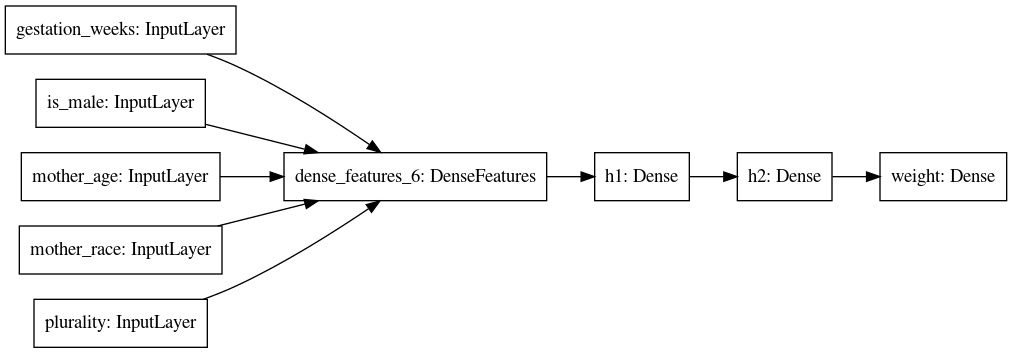

In [66]:
tf.keras.utils.plot_model(
    model=model, to_file="dnn_model.png", show_shapes=False, rankdir="LR")

### Train and evaluate our model
We've built our Keras model using our inputs from our CSV files and the architecture we designed. Let's now run our model by training our model parameters and periodically running an evaluation to track how well we are doing on outside data as training goes on. We'll need to load both our train and eval datasets and send those to our model through the fit method. Make sure you have the right pattern, batch size, and mode when loading the data.

In [67]:
%%time

tf.random.set_seed(33)

TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 1000 * 5  # training dataset repeats, it'll wrap around
NUM_EVALS = 5  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 1000

trainds = load_dataset(
    pattern="./data/babyweight_train*",
    batch_size=TRAIN_BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN)

evalds = load_dataset(
    pattern="./data/babyweight_eval*",
    batch_size=1000,
    mode=tf.estimator.ModeKeys.EVAL).take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

Train for 31 steps, validate for 1 steps
Epoch 1/5
31/31 [==============================] - 2s 61ms/step - loss: 42.7320 - rmse: 5.0342 - mse: 42.7320 - val_loss: 3.9244 - val_rmse: 1.9810 - val_mse: 3.9244
Epoch 2/5
31/31 [==============================] - 0s 13ms/step - loss: 1.7095 - rmse: 1.2776 - mse: 1.7095 - val_loss: 1.2681 - val_rmse: 1.1261 - val_mse: 1.2681
Epoch 3/5
31/31 [==============================] - 0s 12ms/step - loss: 1.2811 - rmse: 1.1199 - mse: 1.2811 - val_loss: 1.1632 - val_rmse: 1.0785 - val_mse: 1.1632
Epoch 4/5
31/31 [==============================] - 0s 13ms/step - loss: 1.1373 - rmse: 1.0564 - mse: 1.1373 - val_loss: 1.1155 - val_rmse: 1.0562 - val_mse: 1.1155
Epoch 5/5
31/31 [==============================] - 0s 13ms/step - loss: 1.1427 - rmse: 1.0564 - mse: 1.1427 - val_loss: 1.0589 - val_rmse: 1.0290 - val_mse: 1.0589
CPU times: user 5.21 s, sys: 844 ms, total: 6.05 s
Wall time: 3.71 s


## Need for regularization

Let's use a high-cardinality feature cross to illustrate the point. In this model, we are predicting taxifare in New York city using a feature cross of lat and lon

In [ ]:
!bq show mlpatterns || bq mk mlpatterns

In [1]:
%%bigquery
CREATE OR REPLACE TABLE mlpatterns.taxi_data AS

SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  pickup_datetime,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM `nyc-tlc.yellow.trips`
# The full dataset has 1+ Billion rows, let's take only 1 out of 1,000 (or 1 Million total)
WHERE ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 1000)) = 1
AND
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0

""


In [19]:
%%bigquery
CREATE OR REPLACE MODEL mlpatterns.taxi_noreg
TRANSFORM(
  fare_amount
  , ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
                            CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday), 2) AS day_hr
  , CONCAT(
     ML.BUCKETIZE(pickuplon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(pickuplat, GENERATE_ARRAY(37, 45, 0.01)),
     ML.BUCKETIZE(dropofflon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(dropofflat, GENERATE_ARRAY(37, 45, 0.01))
  ) AS pickup_and_dropoff
)
OPTIONS(input_label_cols=['fare_amount'], model_type='linear_reg') 
AS

SELECT * FROM mlpatterns.taxi_data

""


In [ ]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL mlpatterns.taxi_noreg)

In [21]:
%%bigquery
CREATE OR REPLACE MODEL mlpatterns.taxi_l2reg
TRANSFORM(
  fare_amount
 , ML.FEATURE_CROSS(STRUCT(CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS STRING) AS dayofweek,
                            CAST(EXTRACT(HOUR FROM pickup_datetime) AS STRING) AS hourofday), 2) AS day_hr
  , CONCAT(
     ML.BUCKETIZE(pickuplon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(pickuplat, GENERATE_ARRAY(37, 45, 0.01)),
     ML.BUCKETIZE(dropofflon, GENERATE_ARRAY(-78, -70, 0.01)),
     ML.BUCKETIZE(dropofflat, GENERATE_ARRAY(37, 45, 0.01))
  ) AS pickup_and_dropoff
)
OPTIONS(input_label_cols=['fare_amount'], model_type='linear_reg', l2_reg=0.5) 
AS

SELECT * FROM mlpatterns.taxi_data

""


In [ ]:
%%bigquery
SELECT SQRT(mean_squared_error) AS rmse FROM ML.EVALUATE(MODEL mlpatterns.taxi_l2reg)

In [24]:
100 * (4.814606 - 4.828183)/4.828183

-0.2812030944146013

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License